# Channel profiles and working with the `_MChiSegmented` file

*This lesson has been written by Simon M. Mudd at the University of Edinburgh*

*Last update 01/03/2020*

In a few of the notebooks we have used `lsdtopotools` to extract a channel profile. The software has a few different ways to extract profiles, but one produces a file with `_MChiSegmented` in the filename. This file has a selection of useful data in it. Lets load the file and have a look.

## Load packages and then load the data

In [1]:
import pandas as pd
import geopandas as gpd
import cartopy as cp
import cartopy.crs as ccrs
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np

We are going to load the csv data, which we generated in the previous notebook. 
We first use a package called `pandas` to do this, and then import that into `geopandas`. 
`pandas` is for dealing with data that you might use excel to look at. So data that might be in a spreadsheet. But it has many powerful data processing options. It was originally developed by a "quant" financial analyst to look at stock trends! But it is a super useful python package for many applications. 

In [2]:
df = pd.read_csv("SorbasChi_MC_MChiSegmented.csv")
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# We have to tell the geopandas data what geographic system we are in by using something called an EPSG code. 
# All major geographic projection and transformation system have this code. 
gdf.crs = "EPSG:4326" 

# The head command shows you what is in the file.
print(gdf.head())

      node  row  col   latitude  longitude     chi  elevation  flow_distance  \
0  3643456  920  227  37.149557  -2.281844  27.895     781.97        77343.0   
1  3647748  921  226  37.149467  -2.281957  27.843     780.85        77329.0   
2  3652041  922  226  37.149377  -2.281958  27.806     779.97        77319.0   
3  3656334  923  226  37.149287  -2.281959  27.769     779.63        77309.0   
4  3660627  924  226  37.149197  -2.281960  27.733     778.55        77299.0   

   drainage_area   m_chi   b_chi  source_key  basin_key  segmented_elevation  \
0       250970.0  16.979  306.52           0          0               780.15   
1       254160.0  17.015  305.64           0          0               779.38   
2       261060.0  16.987  306.26           0          0               778.60   
3       261160.0  16.984  306.41           0          0               778.03   
4       263560.0  16.993  306.18           0          0               777.45   

                    geometry  
0  POIN

Okay, I am not going to explain "chi", or "M_chi" or "b_chi" yet. Most other things should be self explanatory. The exceptions are `source_key` and `basin_key`:

* Each basin is tagged by a `basin_key` so if you pick this, then you isolate the basin. 
* Each channel has a "source" at the tip of the channel. These have a source key. So if you pick this you have the flow path from that source to the outlet. 


## Making new data columns: slope and smoothed slope

Okay, we have flow distance and elevation in this file, but we also want to look at the slope of the channel. To get the slope, we need to calculate the change in elevation over the change in flow distance. The mathematical operation for this is called the gradient (or, if you want to use the notation of derivatives it is `dz/dx`).

The python package `numpy` has a built in function for calculating the gradient (`np.gradient`), which we use below to get the slope along the channel.

In [3]:
z = gdf.elevation
x = gdf.flow_distance
S = np.gradient(np.asarray(z),np.asarray(x))
gdf["slope"] = S
gdf.head()

,node,row,col,latitude,longitude,chi,elevation,flow_distance,drainage_area,m_chi,b_chi,source_key,basin_key,segmented_elevation,geometry,slope
0,3643456,920,227,37.149557,-2.281844,27.895,781.97,77343.0,250970.0,16.979,306.52,0,0,780.15,POINT (-2.28184 37.14956),0.080000
1,3647748,921,226,37.149467,-2.281957,27.843,780.85,77329.0,254160.0,17.015,305.64,0,0,779.38,POINT (-2.28196 37.14947),0.084667
2,3652041,922,226,37.149377,-2.281958,27.806,779.97,77319.0,261060.0,16.987,306.26,0,0,778.60,POINT (-2.28196 37.14938),0.061000
3,3656334,923,226,37.149287,-2.281959,27.769,779.63,77309.0,261160.0,16.984,306.41,0,0,778.03,POINT (-2.28196 37.14929),0.071000
4,3660627,924,226,37.149197,-2.281960,27.733,778.55,77299.0,263560.0,16.993,306.18,0,0,777.45,POINT (-2.28196 37.14920),0.079000


In this notebook, I want to isolate one of the basins. `pandas` has lots of easy ways to isolate data.

In [4]:
# First lets isolate just one of these basins. There is only basin 0 and 1
gdf_b1 = gdf[(gdf['basin_key'] == 0)]
gdf_b1.head()

,node,row,col,latitude,longitude,chi,elevation,flow_distance,drainage_area,m_chi,b_chi,source_key,basin_key,segmented_elevation,geometry,slope
0,3643456,920,227,37.149557,-2.281844,27.895,781.97,77343.0,250970.0,16.979,306.52,0,0,780.15,POINT (-2.28184 37.14956),0.080000
1,3647748,921,226,37.149467,-2.281957,27.843,780.85,77329.0,254160.0,17.015,305.64,0,0,779.38,POINT (-2.28196 37.14947),0.084667
2,3652041,922,226,37.149377,-2.281958,27.806,779.97,77319.0,261060.0,16.987,306.26,0,0,778.60,POINT (-2.28196 37.14938),0.061000
3,3656334,923,226,37.149287,-2.281959,27.769,779.63,77309.0,261160.0,16.984,306.41,0,0,778.03,POINT (-2.28196 37.14929),0.071000
4,3660627,924,226,37.149197,-2.281960,27.733,778.55,77299.0,263560.0,16.993,306.18,0,0,777.45,POINT (-2.28196 37.14920),0.079000


Okay, now lets plot the channel profile and the channel slope. 

Much of the code below is for plotting, but there are some key lines:

    # The main stem channel is the one with the minimum source key in this basin
    min_source = np.amin(gdf_b1.source_key)
    gdf_b2 = gdf_b1[(gdf_b1['source_key'] == min_source)]
    
In thse three lines, we are isolating a `source_key` which is a single channel in the DEM. The basin has lots of channels, but we only want one. The minimm source key in a basin is the longest channel in this dataset. 

<Figure size 720x720 with 0 Axes>

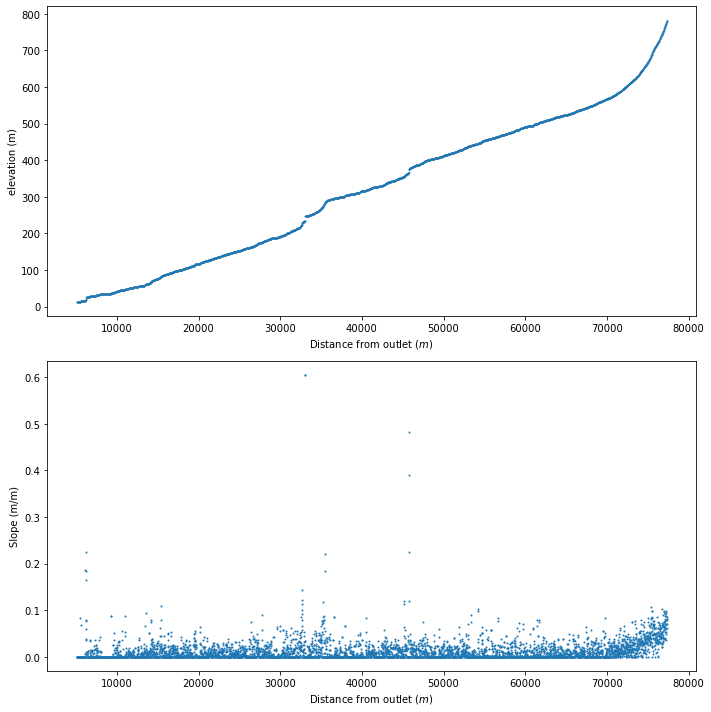

In [5]:
plt.rcParams['figure.figsize'] = [10, 10]

# First lets isolate just one of these basins. There is only basin 0 and 1
gdf_b1 = gdf[(gdf['basin_key'] == 0)]

# The main stem channel is the one with the minimum source key in this basin
min_source = np.amin(gdf_b1.source_key)
gdf_b2 = gdf_b1[(gdf_b1['source_key'] == min_source)]
#gdf_b2 = gdf_b1

# Now make channel profile plots
z = gdf_b2.elevation
x_locs = gdf_b2.flow_distance
S = gdf_b2.slope

# Create two subplots and unpack the output array immediately
plt.clf()
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.scatter(x_locs, z,s = 0.2)
ax2.scatter(x_locs, S,s = 1)


ax1.set_xlabel("Distance from outlet ($m$)")
ax1.set_ylabel("elevation (m)")

ax2.set_xlabel("Distance from outlet ($m$)")
ax2.set_ylabel("Slope (m/m)")

plt.tight_layout()

This slope (bottom figure) is very noisy. One way to deal with this is to smooth the data. We can smooth the data by running a mobing window over it and doing some averaging inside the window. 

Python has lots of tools for this. In this case I use a `rolling` window and I have picked various settings. You don't need to worry about this too much, the only number that you might wanty to play with is the first number after `rolling` which is the number of datapoints in the window. The bigger this number, the more smoothed the data becomes. 

In [12]:
gdf['slope_rolling'] = gdf.slope.rolling(40,win_type='hamming').mean()
gdf.head()

,node,row,col,latitude,longitude,chi,elevation,flow_distance,drainage_area,m_chi,b_chi,source_key,basin_key,segmented_elevation,geometry,slope,slope_rolling
0,3643456,920,227,37.149557,-2.281844,27.895,781.97,77343.0,250970.0,16.979,306.52,0,0,780.15,POINT (-2.28184 37.14956),0.080000,NaN
1,3647748,921,226,37.149467,-2.281957,27.843,780.85,77329.0,254160.0,17.015,305.64,0,0,779.38,POINT (-2.28196 37.14947),0.084667,NaN
2,3652041,922,226,37.149377,-2.281958,27.806,779.97,77319.0,261060.0,16.987,306.26,0,0,778.60,POINT (-2.28196 37.14938),0.061000,NaN
3,3656334,923,226,37.149287,-2.281959,27.769,779.63,77309.0,261160.0,16.984,306.41,0,0,778.03,POINT (-2.28196 37.14929),0.071000,NaN
4,3660627,924,226,37.149197,-2.281960,27.733,778.55,77299.0,263560.0,16.993,306.18,0,0,777.45,POINT (-2.28196 37.14920),0.079000,NaN


<Figure size 720x720 with 0 Axes>

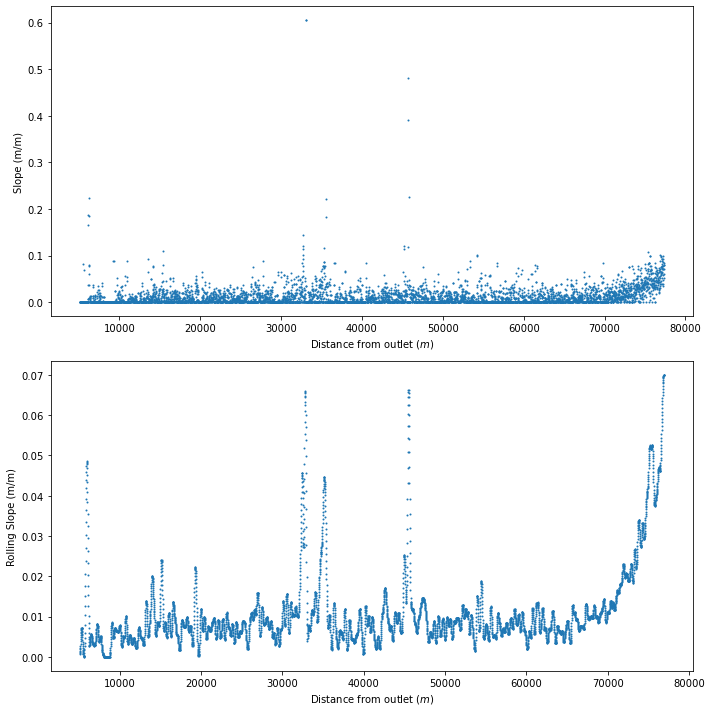

In [13]:
plt.rcParams['figure.figsize'] = [10, 10]

# First lets isolate just one of these basins. There is only basin 0 and 1
gdf_b1 = gdf[(gdf['basin_key'] == 0)]

# The main stem channel is the one with the minimum source key in this basin
min_source = np.amin(gdf_b1.source_key)
gdf_b2 = gdf_b1[(gdf_b1['source_key'] == min_source)]
#gdf_b2 = gdf_b1

# Now make channel profile plots
z = gdf_b2.elevation
x_locs = gdf_b2.flow_distance
S = gdf_b2.slope
SR = gdf_b2.slope_rolling

# Create two subplots and unpack the output array immediately
plt.clf()
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.scatter(x_locs, S,s = 1)
ax2.scatter(x_locs, SR,s = 1)


ax1.set_xlabel("Distance from outlet ($m$)")
ax1.set_ylabel("Slope (m/m)")

ax2.set_xlabel("Distance from outlet ($m$)")
ax2.set_ylabel("Rolling Slope (m/m)")

plt.tight_layout()

## Looking at the gradient and where the high gradient channels are along the channel profile

Okay, the rolling slope allows us to see some spikes in the gradient. Can we see this in the right places along the channel profile?

<Figure size 720x360 with 0 Axes>

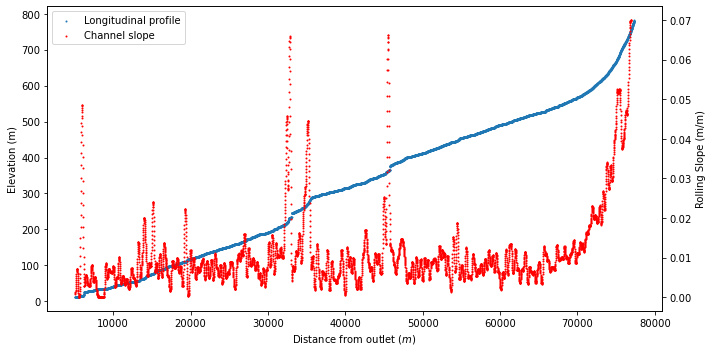

In [23]:
plt.rcParams['figure.figsize'] = [10, 5]

# First lets isolate just one of these basins. There is only basin 0 and 1
gdf_b1 = gdf[(gdf['basin_key'] == 0)]

# The main stem channel is the one with the minimum source key in this basin
# If you want to play with this a bit you can change the source number to look at different channels
min_source = np.amin(gdf_b1.source_key)
gdf_b2 = gdf_b1[(gdf_b1['source_key'] == min_source)]
#gdf_b2 = gdf_b1

# Now make channel profile plots
z = gdf_b2.elevation
x_locs = gdf_b2.flow_distance
S = gdf_b2.slope
SR = gdf_b2.slope_rolling

# Create two subplots and unpack the output array immediately
plt.clf()
f, (ax1) = plt.subplots(1, 1)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Make the scatter plots
ax1.scatter(x_locs, z,s = 1, label='Longitudinal profile')
ax2.scatter(x_locs, SR,s = 1,c="r", label='Channel slope')

# Some code to make sure the legend renders on the same axis
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)


ax1.set_xlabel("Distance from outlet ($m$)")
ax1.set_ylabel("Elevation (m)")

ax2.set_xlabel("Distance from outlet ($m$)")
ax2.set_ylabel("Rolling Slope (m/m)")

plt.tight_layout()

Well, it looks like those really steep bits in the channel profile are showing up gradient data. That is good: at least we know the data looks sensible. But, in the headwaters, there are some steep sections. Can we tell if these are steeper than the rest of the channel if we control for drainage area?

The traditional way to do this was to use a plot of the logarithm of slope against the logarithm of drainage area. The theory behind that is explained in the lessons in the `Channel_incision` directory. 

Here I am just going to show you the data. 

## Slope and area

<Figure size 720x720 with 0 Axes>

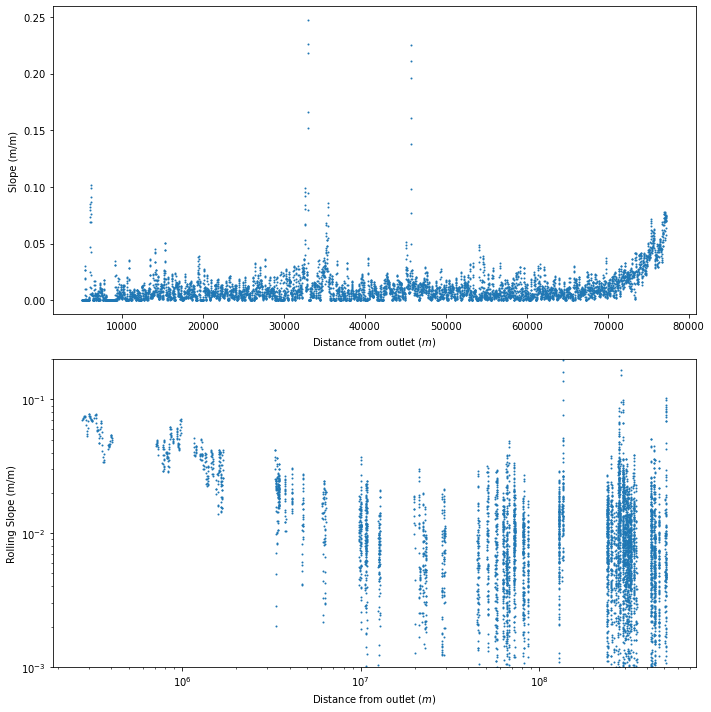

In [9]:
plt.rcParams['figure.figsize'] = [10, 10]

# First lets isolate just one of these basins. There is only basin 0 and 1
gdf_b1 = gdf[(gdf['basin_key'] == 0)]

# The main stem channel is the one with the minimum source key in this basin
min_source = np.amin(gdf_b1.source_key)
gdf_b2 = gdf_b1[(gdf_b1['source_key'] == min_source)]
#gdf_b2 = gdf_b1

# Now make channel profile plots
z = gdf_b2.elevation
x_locs = gdf_b2.flow_distance
S = gdf_b2.slope
SR = gdf_b2.slope_rolling
A = gdf_b2.drainage_area

# Create two subplots and unpack the output array immediately
plt.clf()
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.scatter(x_locs, SR,s = 1)
ax2.scatter(A, SR,s = 1)


ax1.set_xlabel("Distance from outlet ($m$)")
ax1.set_ylabel("Slope (m/m)")

ax2.set_xlabel("Distance from outlet ($m$)")
ax2.set_ylabel("Rolling Slope (m/m)")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylim(0.001,0.2)

plt.tight_layout()

So the plot above is the slope-area plot. As you can see, it is very messy. If you want to get a sensible S-A relationship out of this you need to do some more work of binning and averaging the data. Remember we have already smoothed the data! So getting a clean slope-area plot requires massaging the data quite a lot. 

The problem here is that slope data varies a lot along the channel. Slope is noisy because channels are naturally bumpy, and also because there are errors in the topographic data. In addition, drainage area jumps every time there is a junction (you add the two drainage areas of the tributaries together) so your area data has big gaps. 

So in the traditional way to analyse channels, figuring out what part of the channel is relatively steep (that is what is steeper after you control for drainage area) is quite challenging. 

Leigh Royden, with collaborators, developed a method to get around this noise: she presented it at a conference in 2000 and then never published the work in a journal. She then published it with another author 13 years later:

https://onlinelibrary.wiley.com/doi/abs/10.1002/esp.3302

Royden, L., Perron, J.T., 2013. Solutions of the stream power equation and application to the evolution of river longitudinal profiles. Journal of Geophysical Research: Earth Surface 118, 497–518. https://doi.org/10.1002/jgrf.20031

The theory is explained in other notebooks (`channel_incision/Lesson_06_integral_transform.ipynb`). We are going to concentrate on the outcome of that work. 

## Steepness data with chi profiles

<Figure size 720x720 with 0 Axes>

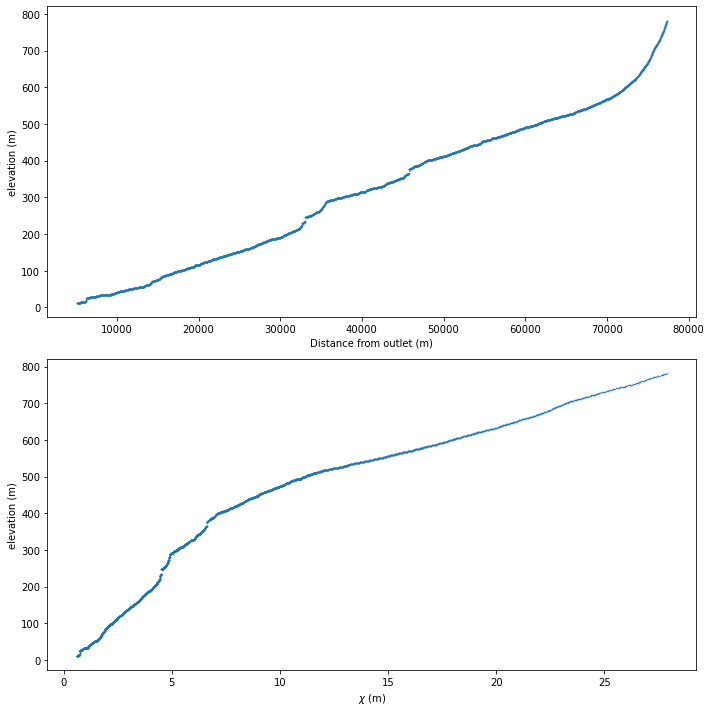

In [11]:
plt.rcParams['figure.figsize'] = [10, 10]

# First lets isolate just one of these basins. There is only basin 0 and 1
gdf_b1 = gdf[(gdf['basin_key'] == 0)]

# The main stem channel is the one with the minimum source key in this basin
min_source = np.amin(gdf_b1.source_key)
gdf_b2 = gdf_b1[(gdf_b1['source_key'] == min_source)]
#gdf_b2 = gdf_b1

# Now make channel profile plots
z = gdf_b2.elevation
x_locs = gdf_b2.flow_distance
chi = gdf_b2.chi

# Create two subplots and unpack the output array immediately
plt.clf()
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.scatter(x_locs, z,s = 0.2)
ax2.scatter(chi, z,s = 0.2)


ax1.set_xlabel("Distance from outlet (m)")
ax1.set_ylabel("elevation (m)")

ax2.set_xlabel("$\chi$ (m)")
ax2.set_ylabel("elevation (m)")

plt.tight_layout()

What is this? In short, the $\chi$ coordinate is _transformed_ (a fancy way of saying we applied some maths to it) and the transformation included drainage area. So the $\chi$ coordinate is like the flow distance but we have wrapped drainage area into it.

This coordinate was **specifically designed** so that the gradient in the "chi plot" (that is, the bottom plot which is a plot a $\chi$ vs elevation) corresponds to the relative steepness of the channel. And by relative steepness I mean steepness normalised for drainage area.

As it turns out, the program that produced the data also calculates the gradient in the $\chi$ vs elevation plot. This gradient is called `m_chi`. There is a bunch of statistics behind the way it does it, and if you are in need of some bedtime reading in order to battle insomnia, you can read the details here:

*Mudd, S.M., Attal, M., Milodowski, D.T., Grieve, S.W.D., Valters, D.A., 2014. A statistical framework to quantify spatial variation in channel gradients using the integral method of channel profile analysis. Journal of Geophysical Research: Earth Surface 119, 138–152. https://doi.org/10.1002/2013JF002981*

In the plot below we look at that data:

<Figure size 720x360 with 0 Axes>

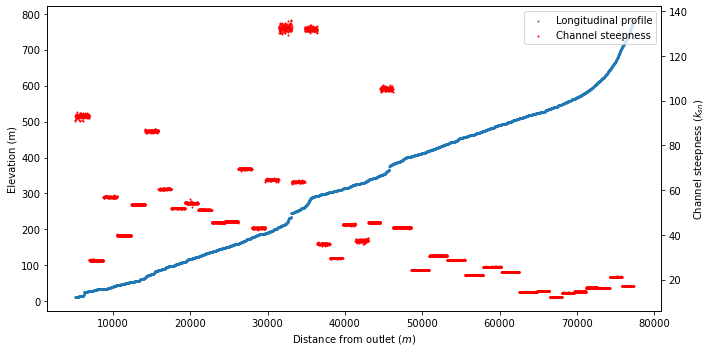

In [25]:
plt.rcParams['figure.figsize'] = [10, 5]

# First lets isolate just one of these basins. There is only basin 0 and 1
gdf_b1 = gdf[(gdf['basin_key'] == 0)]

# The main stem channel is the one with the minimum source key in this basin
# If you want to play with this a bit you can change the source number to look at different channels
min_source = np.amin(gdf_b1.source_key)
gdf_b2 = gdf_b1[(gdf_b1['source_key'] == min_source)]
#gdf_b2 = gdf_b1

# Now make channel profile plots
z = gdf_b2.elevation
x_locs = gdf_b2.flow_distance
m_chi = gdf_b2.m_chi
chi = gdf_b2.chi

# Create two subplots and unpack the output array immediately
plt.clf()
f, (ax1) = plt.subplots(1, 1)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Make the scatter plots
ax1.scatter(x_locs, z,s = 1, label='Longitudinal profile')
ax2.scatter(x_locs, m_chi,s = 1,c="r", label='Channel steepness')

# Some code to make sure the legend renders on the same axis
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

# These are just the labels for the figure
ax1.set_xlabel("Distance from outlet ($m$)")
ax1.set_ylabel("Elevation (m)")

ax2.set_xlabel("Distance from outlet ($m$)")
ax2.set_ylabel("Channel steepness ($k_{sn}$)")

plt.tight_layout()

Okay, this plot shows the channel profile alongside the channel steepness. This resembles the slope plot, but these steepnesses are normalised for drainage area. 

What this is showing is that
1. The top of the channel is not steep relative to the bottom of the channel!
2. The are some very steep bits in the middle. We call the knickpoints. 
3. There seem to be three prominent knickpoints in the middle of the channel (at around 30km from the outlet and also at around 45 km from the outlet). 
4. The channels below the knickpoints are a lot steeper than channels above the knickpoints. 

We can also skip having two plots and just colour the points in the channel profile by their steepness, which I do below:

<Figure size 720x360 with 0 Axes>

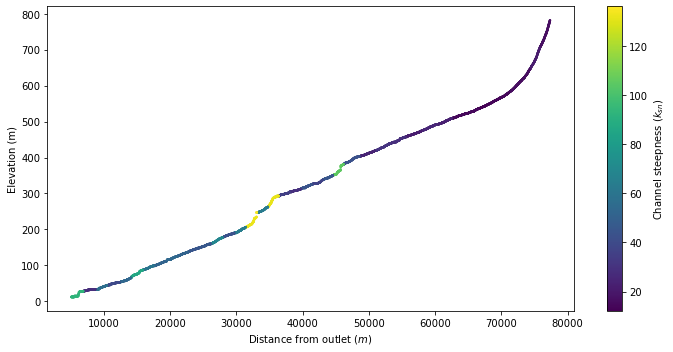

In [31]:
plt.rcParams['figure.figsize'] = [10, 5]

# First lets isolate just one of these basins. There is only basin 0 and 1
gdf_b1 = gdf[(gdf['basin_key'] == 0)]

# The main stem channel is the one with the minimum source key in this basin
# If you want to play with this a bit you can change the source number to look at different channels
min_source = np.amin(gdf_b1.source_key)
gdf_b2 = gdf_b1[(gdf_b1['source_key'] == min_source)]
#gdf_b2 = gdf_b1

# Now make channel profile plots
z = gdf_b2.elevation
x_locs = gdf_b2.flow_distance
m_chi = gdf_b2.m_chi
chi = gdf_b2.chi

# Create two subplots and unpack the output array immediately
plt.clf()
f, (ax1) = plt.subplots(1, 1)
#ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Make the scatter plots
cs = ax1.scatter(x_locs, z,s = 2, c=m_chi, cmap="viridis",label='Longitudinal profile')

cbar = f.colorbar(cs)
cbar.set_label('Channel steepness ($k_{sn}$)')

ax1.set_xlabel("Distance from outlet ($m$)")
ax1.set_ylabel("Elevation (m)")

#ax2.set_xlabel("Distance from outlet ($m$)")
#ax2.set_ylabel("Channel steepness ($k_{sn}$)")

plt.tight_layout()